# Project ideas and thoughts:
- Identify 3 demographic groups:
    - customers who respond to offers (received, viewed, and completed the offer)
    - customers who don't respond to offers (received, viewed, not completed the offer)
    - customers who completed offers without viewing the offers (those who would have made a purchase without the offer)


- Predict offer completion rate per customer
- Send offers to customers with a certain threshold completion rate
- Exclude customers who would make a purchase without the offer

In [76]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-whitegrid')

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Description of **RENAMED** variables in the **RENAMED** datasets:

**offers (portfolio.json)**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* min_spend (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* expire_days (int) - time for offer to expire in days
* channels (list of strings) - distribution channels of the offer

**customers (profile.json)**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**events (transcript.json)**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* customer_id (str) - customer id
* hours_from_test (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [96]:
# read in the json files
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
customers = pd.read_json('data/profile.json', orient='records', lines=True)
events = pd.read_json('data/transcript.json', orient='records', lines=True)

# change column names and print df shape
offers.columns = ['reward','channels','min_spend','expire_days','offer_type','id']
customers.columns = ['gender','age','id','became_member_on','income']
events.columns = ['customer_id','event','value','hours_from_test']
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 17000 rows
events has 306534 rows


# Data Cleaning

In [92]:
# Clean the events data
for dic in events.value:
    if list(dic.keys()) == ['offer id']:
        dic['offer_id'] = dic.pop('offer id')

# Concat and transform the events data
temp = pd.DataFrame(events.value.to_list())
events = pd.concat([events,temp],axis=1)
events.rename(columns={'reward':'reward_received', 'amount':'amount_spent'},inplace=True)
events.drop('value',axis=1,inplace=True)
events.head()

,customer_id,event,hours_from_test,offer_id,amount_spent,reward_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [85]:
events.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [86]:
events.isnull().mean()

customer_id        0.000000
event              0.000000
hours_from_test    0.000000
offer_id           0.453304
amount_spent       0.546696
reward_received    0.890456
dtype: float64

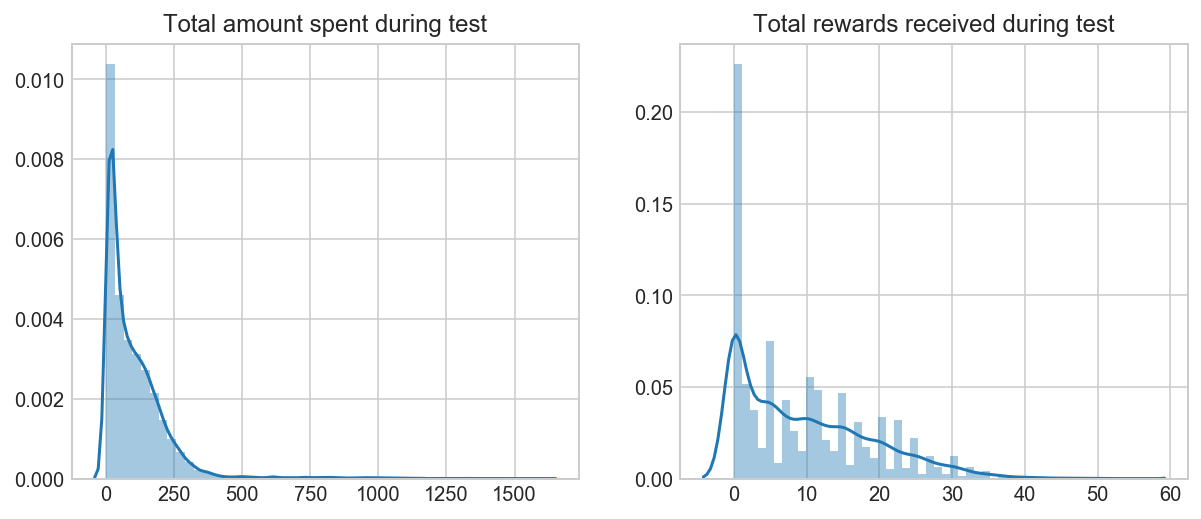

In [64]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(events.groupby(['customer_id']).amount_spent.sum());
plt.title('Total amount spent during test'); plt.xlabel('');
plt.subplot(1,2,2)
sns.distplot(events.groupby(['customer_id']).reward_received.sum());
plt.title('Total rewards received during test'); plt.xlabel('');

# IMPORTANT - Define Customer Response
- A user can receive an offer, never actually view the offer, and still complete the offer
- We want to find customers who were influenced by the offer - those who **RECEIVED, VIEWED, AND COMPLETED THE OFFER**
- Also, we want to find customers who would have made purchases without offers - those who **RECEIVED, COMPLETED, BUT DIDN'T VIEW THE OFFER**

The purpose of this project is to help Starbucks better decisions on sending out offers in order to save money and increase sales. If we are able to predict customer response to offers, we can help reduce losses in revenue (discount, buy one get one free) by not sending offers to certain customers, as well as increase sales by sending offers to certain customers.

### Merge events and offers dataframes into events_offers dataframe
- Remove transactions to only include 3 events/activities:
    - offer received
    - offer viewed
    - offer completed
- Remove informational offers to only include 2 offer types:
    - bogo
    - discount
- Converted 8 unique offer ids to letters from A to H for more in-depth analysis later on

In [94]:
# Merge offers to events
events_offers = pd.merge(events, offers, how='left', left_on='offer_id', right_on='id')
#events_offers = events_offers.query("event != 'transaction'") #include only offer related activities
events_offers = events_offers.query("offer_type != 'informational'") #include only offers that can be tracked with completion
events_offers.drop(['id'],axis=1,inplace=True)

offerid_dict = dict(zip(set(events_offers.offer_id), [i for i in 'ABCDEFGHIJ']))
events_offers.offer_id = events_offers.offer_id.apply(lambda x: offerid_dict[x])
events_offers.reset_index(drop=True, inplace=True)

removed_customers = np.setdiff1d(events.customer_id.unique(), events_offers.customer_id.unique(), assume_unique=True)

# # Create dummy variables for channels
# mlb = MultiLabelBinarizer()
# dummy_channels = pd.DataFrame(mlb.fit_transform(events_offers.channels), columns=mlb.classes_)
# events_offers = pd.concat([events_offers,dummy_channels],axis=1)
# events_offers.drop('channels',axis=1,inplace=True)
# print(f'Unique offer types are: {events_offers.offer_type.unique()}')
# print(f'There are {events_offers.offer_id.nunique()} unique offers in the dataset')
print(len(removed_customers), 'customers are removed from the filter')
print(events_offers.event.unique())
print(events_offers.offer_type.unique())
print(events_offers.offer_id.unique())
events_offers.head()

4 customers are removed from the filter
['offer received' 'offer viewed' 'transaction' 'offer completed']
['bogo' 'discount' nan]
['B' 'I' 'D' 'G' 'E' 'C' 'H' 'F' 'A']


,customer_id,event,hours_from_test,offer_id,amount_spent,reward_received,reward,channels,min_spend,expire_days,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,B,NaN,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,I,NaN,NaN,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,D,NaN,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,G,NaN,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,E,NaN,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [95]:
events_offers.query("customer_id == '78afa995795e4d85b5d9ceeca43f5fef'")[['customer_id','event','hours_from_test','amount_spent','reward_received','offer_type']]

,customer_id,event,hours_from_test,amount_spent,reward_received,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,bogo
12685,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,NaN,bogo
43208,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN
43209,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,bogo
45102,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN
78679,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,NaN
83525,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,NaN
128802,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,NaN
137518,78afa995795e4d85b5d9ceeca43f5fef,offer received,408,NaN,NaN,bogo
147727,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,408,NaN,NaN,bogo


In [72]:
events_offers.customer_id.nunique()

16928

In [70]:
len(customer_funnels)

16928

In [61]:
customer_funnels = events_offers.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
customer_funnels = pd.pivot(customer_funnels, index='customer_id', columns='event', values='count')
customer_funnels.columns = [col.replace(' ', '_') for col in customer_funnels.columns]
customer_funnels.sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
b6d94c567b25454a9262c4f5c3ac996c,4.0,4.0,4.0
c3174ea1e54e493e891c8615885384ce,1.0,3.0,3.0
46c03cc2bbfc4489a3f07d71c852bc9a,1.0,3.0,2.0
a22c0779ef004410b831f9eb0090f331,1.0,4.0,4.0
6e89f03e9bb94a0697104ded595c721e,4.0,4.0,3.0


- 100% customers in this data received at least 1 offer
- 24.5% customers didn't complete the offer
- 2.4% customers didn't view the offer

In [62]:
customer_funnels.isnull().mean() * 100

offer_completed    24.539225
offer_received      0.000000
offer_viewed        2.392486
dtype: float64

# How much did each demographic group spend?

In [64]:
# Customers who completed the funnel - responded to offers
responded = customer_funnels.dropna()
responded['completion_rate'] = responded.offer_completed / responded.offer_received
print(round(len(responded)/len(customer_funnels)*100,2), '% customers responded to offers')
responded.head()

74.4 % customers responded to offers


,offer_completed,offer_received,offer_viewed,completion_rate
customer_id,,,,
0009655768c64bdeb2e877511632db8f,3.0,3.0,2.0,1.00
0011e0d4e6b944f998e987f904e8c1e5,3.0,3.0,3.0,1.00
0020c2b971eb4e9188eac86d93036a77,3.0,4.0,2.0,0.75
0020ccbbb6d84e358d3414a3ff76cffd,3.0,3.0,3.0,1.00
003d66b6608740288d6cc97a6903f4f0,3.0,3.0,2.0,1.00


In [65]:
# Customers who completed the offer without viewing the offer
not_responded = customer_funnels[customer_funnels.offer_completed.isnull()]
print(round(len(not_responded)/len(customer_funnels)*100,2), '% customers did not respond to any offer')
not_responded.head()

24.54 % customers did not respond to any offer


,offer_completed,offer_received,offer_viewed
customer_id,,,
00116118485d4dfda04fdbaba9a87b5c,NaN,2.0,2.0
0063def0f9c14bc4805322a488839b32,NaN,4.0,4.0
00857b24b13f4fe0ad17b605f00357f5,NaN,5.0,3.0
008d7088107b468893889da0ede0df5c,NaN,4.0,3.0
0092a132ead946ceb30d11a1ed513d20,NaN,5.0,5.0


In [66]:
# Customers who completed the offer without viewing the offer
# An offer is potentially a cost to the company, so if the customer makes purchases anyway, don't need to send them offers
completed_not_viewed = customer_funnels[customer_funnels.offer_completed.notnull() & customer_funnels.offer_viewed.isnull()]
completed_not_viewed['completion_rate'] = completed_not_viewed.offer_completed / completed_not_viewed.offer_received
print(round(len(completed_not_viewed)/len(customer_funnels)*100,2), '% customers completed offers without viewing offer')
completed_not_viewed.head()

1.06 % customers completed offers without viewing offer


,offer_completed,offer_received,offer_viewed,completion_rate
customer_id,,,,
016871ea865d4338975026ae08d221d0,1.0,3.0,NaN,0.333333
03c23b2ec84f4c5296e99c939288bcd4,2.0,2.0,NaN,1.000000
04ca4f4a66934cec9d3bbd8833572cf7,3.0,3.0,NaN,1.000000
04ea45ec66574a618b0918834ee08fed,2.0,4.0,NaN,0.500000
04fa747cd2d841bcaf08f0a64e82bbef,1.0,5.0,NaN,0.200000


In [75]:
# Make sure these 3 demographic groups 
assert len(responded) + len(not_responded) + len(completed_not_viewed) == len(customer_funnels), '3 demographic groups not broken down correctly'

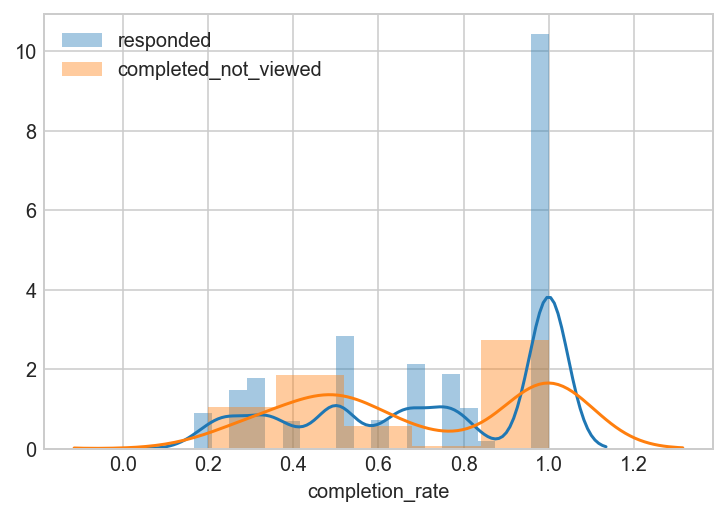

In [56]:
sns.distplot(responded.completion_rate, label='responded');
sns.distplot(completed_not_viewed.completion_rate, label='completed_not_viewed');
plt.legend();

In [163]:
# def get_ids(df):

#     return df.index

In [162]:
# def plot_demographic(ids):

#     df = customers[customers.id.isin(ids)]

#     sns.kdeplot(customers.query("discount == 1")[feature], label='responded');
#     sns.kdeplot(customers.query("discount == 0")[feature], label='not responded');
#     plt.title(f'{feature} distribution by discount response');

### Create pivot tables that describe customer funnels
- Write a function to create a customer funnel table by offer_id **OR** offer_type
- The objective is to find out the list of customers who responded to a certain offer_id **OR** offer_type
- There are only 2 types of offers: BOGO and discount
- There are 8 types of DISTINCT offers, defined as offer A through offer H, with different features such as days to expire, minimum spend
- Analyze the demographics from both granularities to extract insights

In [188]:
# Function to create pivot table by offer type or offer id
def create_offer_pivot(offer_id=False, offer_type=False):

    '''
    create a pivot table for a certain offer - discount, bogo, informational
    showing the number of offers received, viewed and completed for each customer

    input:
        offer_type - discount, bogo, informational
    output:
        df_pivot - a pivot table with values for each activity - offer_completed, offer_received, offer_viewed
    '''

    if offer_id:
        df = events_offers[events_offers.offer_id == offer_id]
        df = df.groupby(['customer_id','event']).event.count().to_frame()
        df.columns = ['count']
        df.reset_index(inplace=True)
        df_pivot = pd.pivot(df, index='customer_id', columns='event', values='count')
        df_pivot.columns = [i.replace(' ','_') for i in df_pivot.columns]

    if offer_type:
        df = events_offers[events_offers.offer_type == offer_type]
        df = df.groupby(['customer_id','event']).event.count().to_frame()
        df.columns = ['count']
        df.reset_index(inplace=True)
        df_pivot = pd.pivot(df, index='customer_id', columns='event', values='count')
        df_pivot.columns = [i.replace(' ','_') for i in df_pivot.columns]

    return df_pivot

In [191]:
discount_funnel = create_offer_pivot(offer_type='discount')
discount_funnel.head()

,offer_completed,offer_received,offer_viewed
customer_id,,,
0009655768c64bdeb2e877511632db8f,2.0,2.0,1.0
0011e0d4e6b944f998e987f904e8c1e5,2.0,2.0,2.0
0020c2b971eb4e9188eac86d93036a77,2.0,2.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.0,1.0
003d66b6608740288d6cc97a6903f4f0,3.0,3.0,2.0


In [192]:
bogo_funnel = create_offer_pivot(offer_type='bogo')
bogo_funnel.head()

,offer_completed,offer_received,offer_viewed
customer_id,,,
0009655768c64bdeb2e877511632db8f,1.0,1.0,1.0
00116118485d4dfda04fdbaba9a87b5c,NaN,2.0,2.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,1.0
0020c2b971eb4e9188eac86d93036a77,1.0,2.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,2.0,2.0,2.0


In [ ]:
sns.kdeplot(discount_funnel.offer_completed)

In [38]:
# An example - events of offer A by each customer
create_offer_pivot(offer_id='A').sample(5)

,offer_completed,offer_received,offer_viewed
customer_id,,,
8546396e46394221a3d889aba0593e5a,NaN,1.0,1.0
ed67dd8bc29b455ab00407fa2500b7d6,1.0,1.0,1.0
61dc3aeeb2264c6288b702608e50813f,1.0,1.0,1.0
100a681a8c534df095ee4aedfe9fdc22,1.0,1.0,1.0
121a62fa7f5349ad90d97dad47e7194d,1.0,1.0,1.0


In [39]:
# Function to return list of responded customer ids by offer type
def get_responded_ids(offer_id=False, offer_type=False):
    '''
    get a list of customer ids who responded to a certain offer

    input: 
        offer_type - discount, bogo, informational
    output:
        ids - list of customer ids who responded to this offer type
    '''
    
    if offer_id:
        offer_pivot = create_offer_pivot(offer_id=offer_id)
        ids = list(offer_pivot.dropna().index)
    if offer_type:
        offer_pivot = create_offer_pivot(offer_type=offer_type)
        ids = list(offer_pivot.dropna().index)

    return ids

In [33]:
# Sample of 5 customers who responded to offer A
get_responded_ids(offer_id='A')[:5]

['0009655768c64bdeb2e877511632db8f',
 '0020c2b971eb4e9188eac86d93036a77',
 '003d66b6608740288d6cc97a6903f4f0',
 '00426fe3ffde4c6b9cb9ad6d077a13ea',
 '004b041fbfe44859945daa2c7f79ee64']

In [34]:
# Sample of 5 customers who responded to all discount offers
get_responded_ids(offer_type='discount')[:5]

['0009655768c64bdeb2e877511632db8f',
 '0011e0d4e6b944f998e987f904e8c1e5',
 '0020c2b971eb4e9188eac86d93036a77',
 '0020ccbbb6d84e358d3414a3ff76cffd',
 '003d66b6608740288d6cc97a6903f4f0']

### Implementation
While we have a function to extract customer ids based on offer_type and offer_id, we can create new features in the customers data - whether the customer responded to offer A, offer B, ... discount offers, BOGO offers, etc.

In [172]:
# Create new feature for customer data - membership_days
customers.became_member_on = pd.to_datetime(customers.became_member_on, format='%Y%m%d')
most_recent = max(customers.became_member_on)
customers['membership_days'] = customers.became_member_on.apply(lambda x: most_recent - x).dt.days

# # Create new features - whether customer responded to offers A - H
# for id in events_offers.offer_id.unique():
#     customers[id] = customers.id.isin(get_responded_ids(offer_id=id)).astype(int)

# # Create new features - whether customer responded to discount offers/BOGO offers
# for type in events_offers.offer_type.unique():
#     customers[type] = customers.id.isin(get_responded_ids(offer_type=type)).astype(int)

customers['response'] = customers.id.isin(responded.index).astype(int)

customers.head()

,gender,age,id,became_member_on,income,membership_days,G,F,D,A,C,H,E,B,response
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,0,0,0,1,0,0,1,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,0,0,0,0,0,0,0,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,0,0,0,0,0,0,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,1,0,0,0,0,1,0,1,1
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,0,0,0,0,0,0,0,0,0


# EDA - How does different demographics respond to offers?
### Create a function to plot distributions of demographic features such as:
- Income Level
- Gender/Age
- Days of Membership

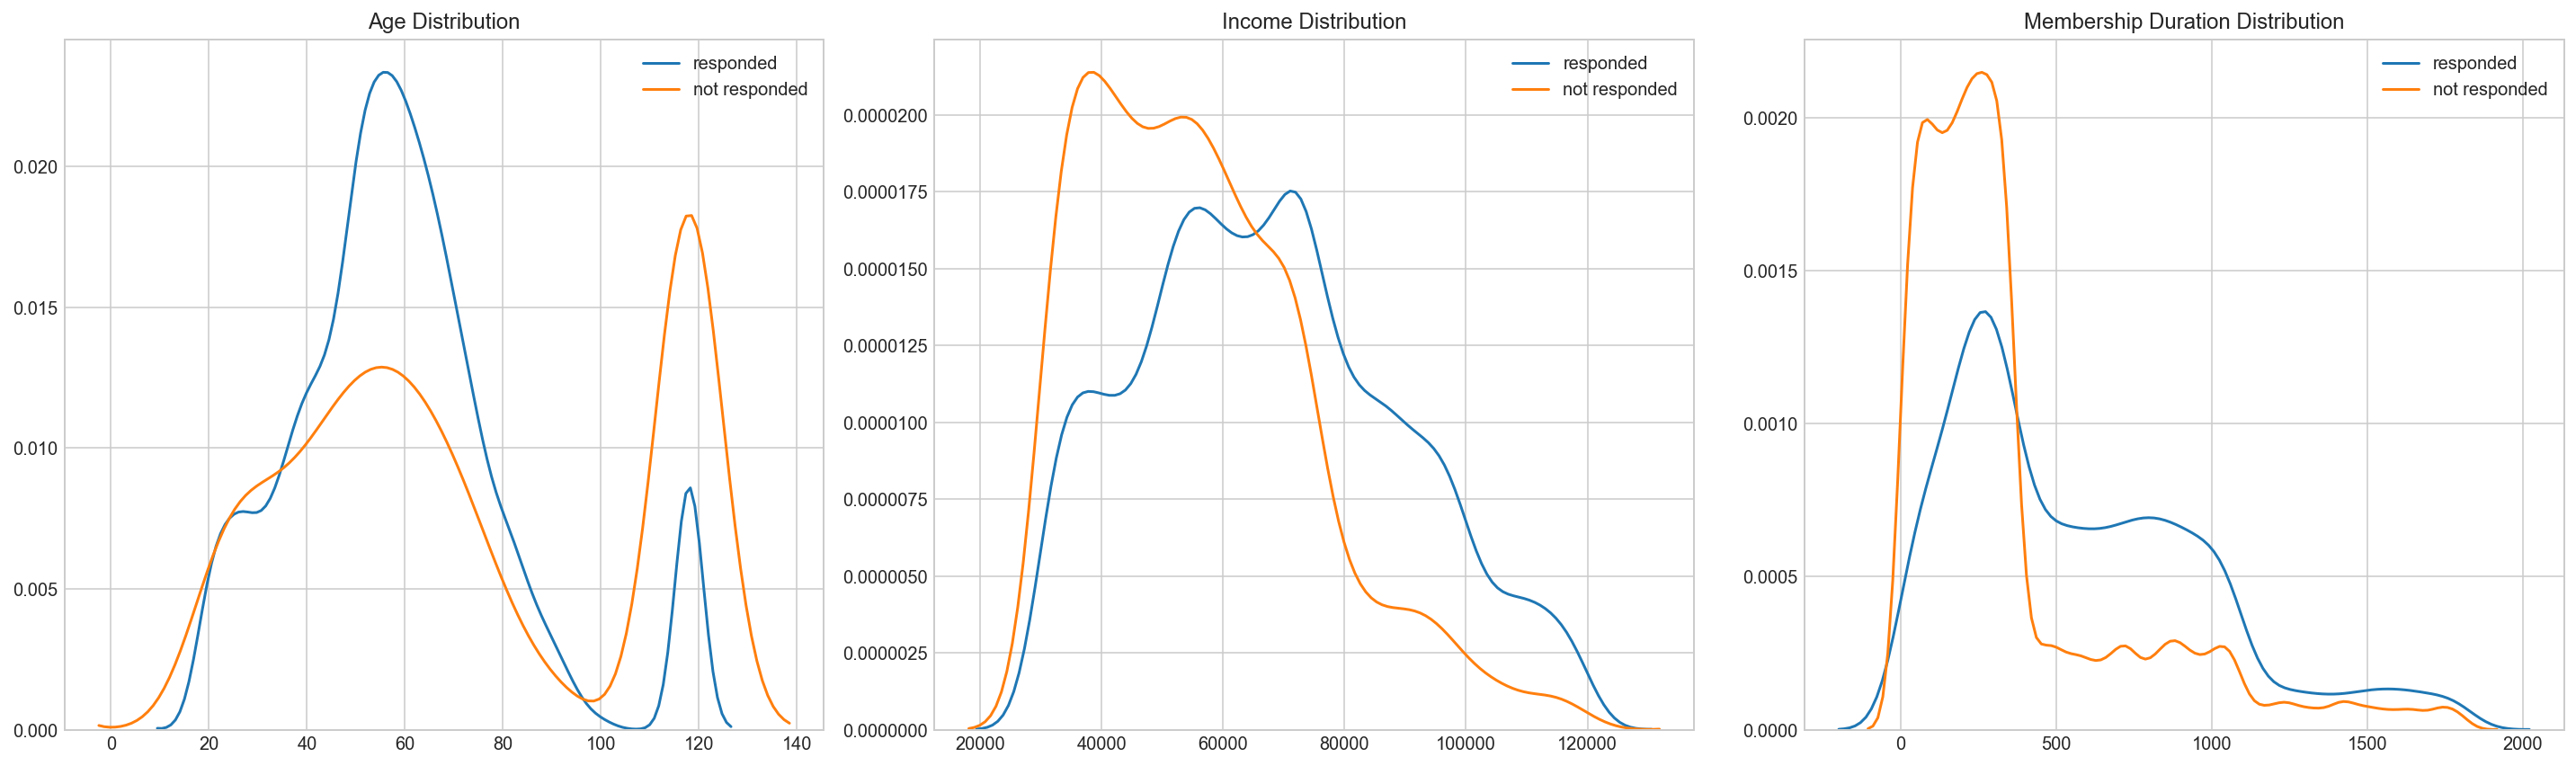

In [185]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.kdeplot(customers.query("response == 1").age, label='responded');
sns.kdeplot(customers.query("response == 0").age, label='not responded');
plt.title('Age Distribution')

plt.subplot(1,3,2)
sns.kdeplot(customers.query("response == 1").income, label='responded');
sns.kdeplot(customers.query("response == 0").income, label='not responded');
plt.title('Income Distribution')

plt.subplot(1,3,3)
sns.kdeplot(customers.query("response == 1").membership_days, label='responded');
sns.kdeplot(customers.query("response == 0").membership_days, label='not responded');
plt.title('Days of Membership Distribution')
plt.tight_layout()

In [186]:
def plot_distribution_by_offer_type(feature):

    # Plot distribution comparisons
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    sns.kdeplot(customers.query("discount == 1")[feature], label='responded');
    sns.kdeplot(customers.query("discount == 0")[feature], label='not responded');
    plt.title(f'{feature} distribution by discount response');

    plt.subplot(1,2,2)
    sns.kdeplot(customers.query("bogo == 1")[feature], label='responded');
    sns.kdeplot(customers.query("bogo == 0")[feature], label='not responded');
    plt.title(f'{feature} distribution by BOGO response');
    plt.tight_layout()

### Create a function to plot distributions by the 8 distinct offers

In [54]:
def plot_distribution_by_offer_id(feature):

    plt.figure(figsize=(20,15))
    for i, offer in enumerate(['A','B','C','D','E','F','G','H']):
        plt.subplot(3,3,i+1)
        sns.kdeplot(customers[customers[offer] == 1][feature], label='responded');
        sns.kdeplot(customers[customers[offer] == 0][feature], label='not responded');
        plt.title(f'{feature} distribution by offer {offer}');

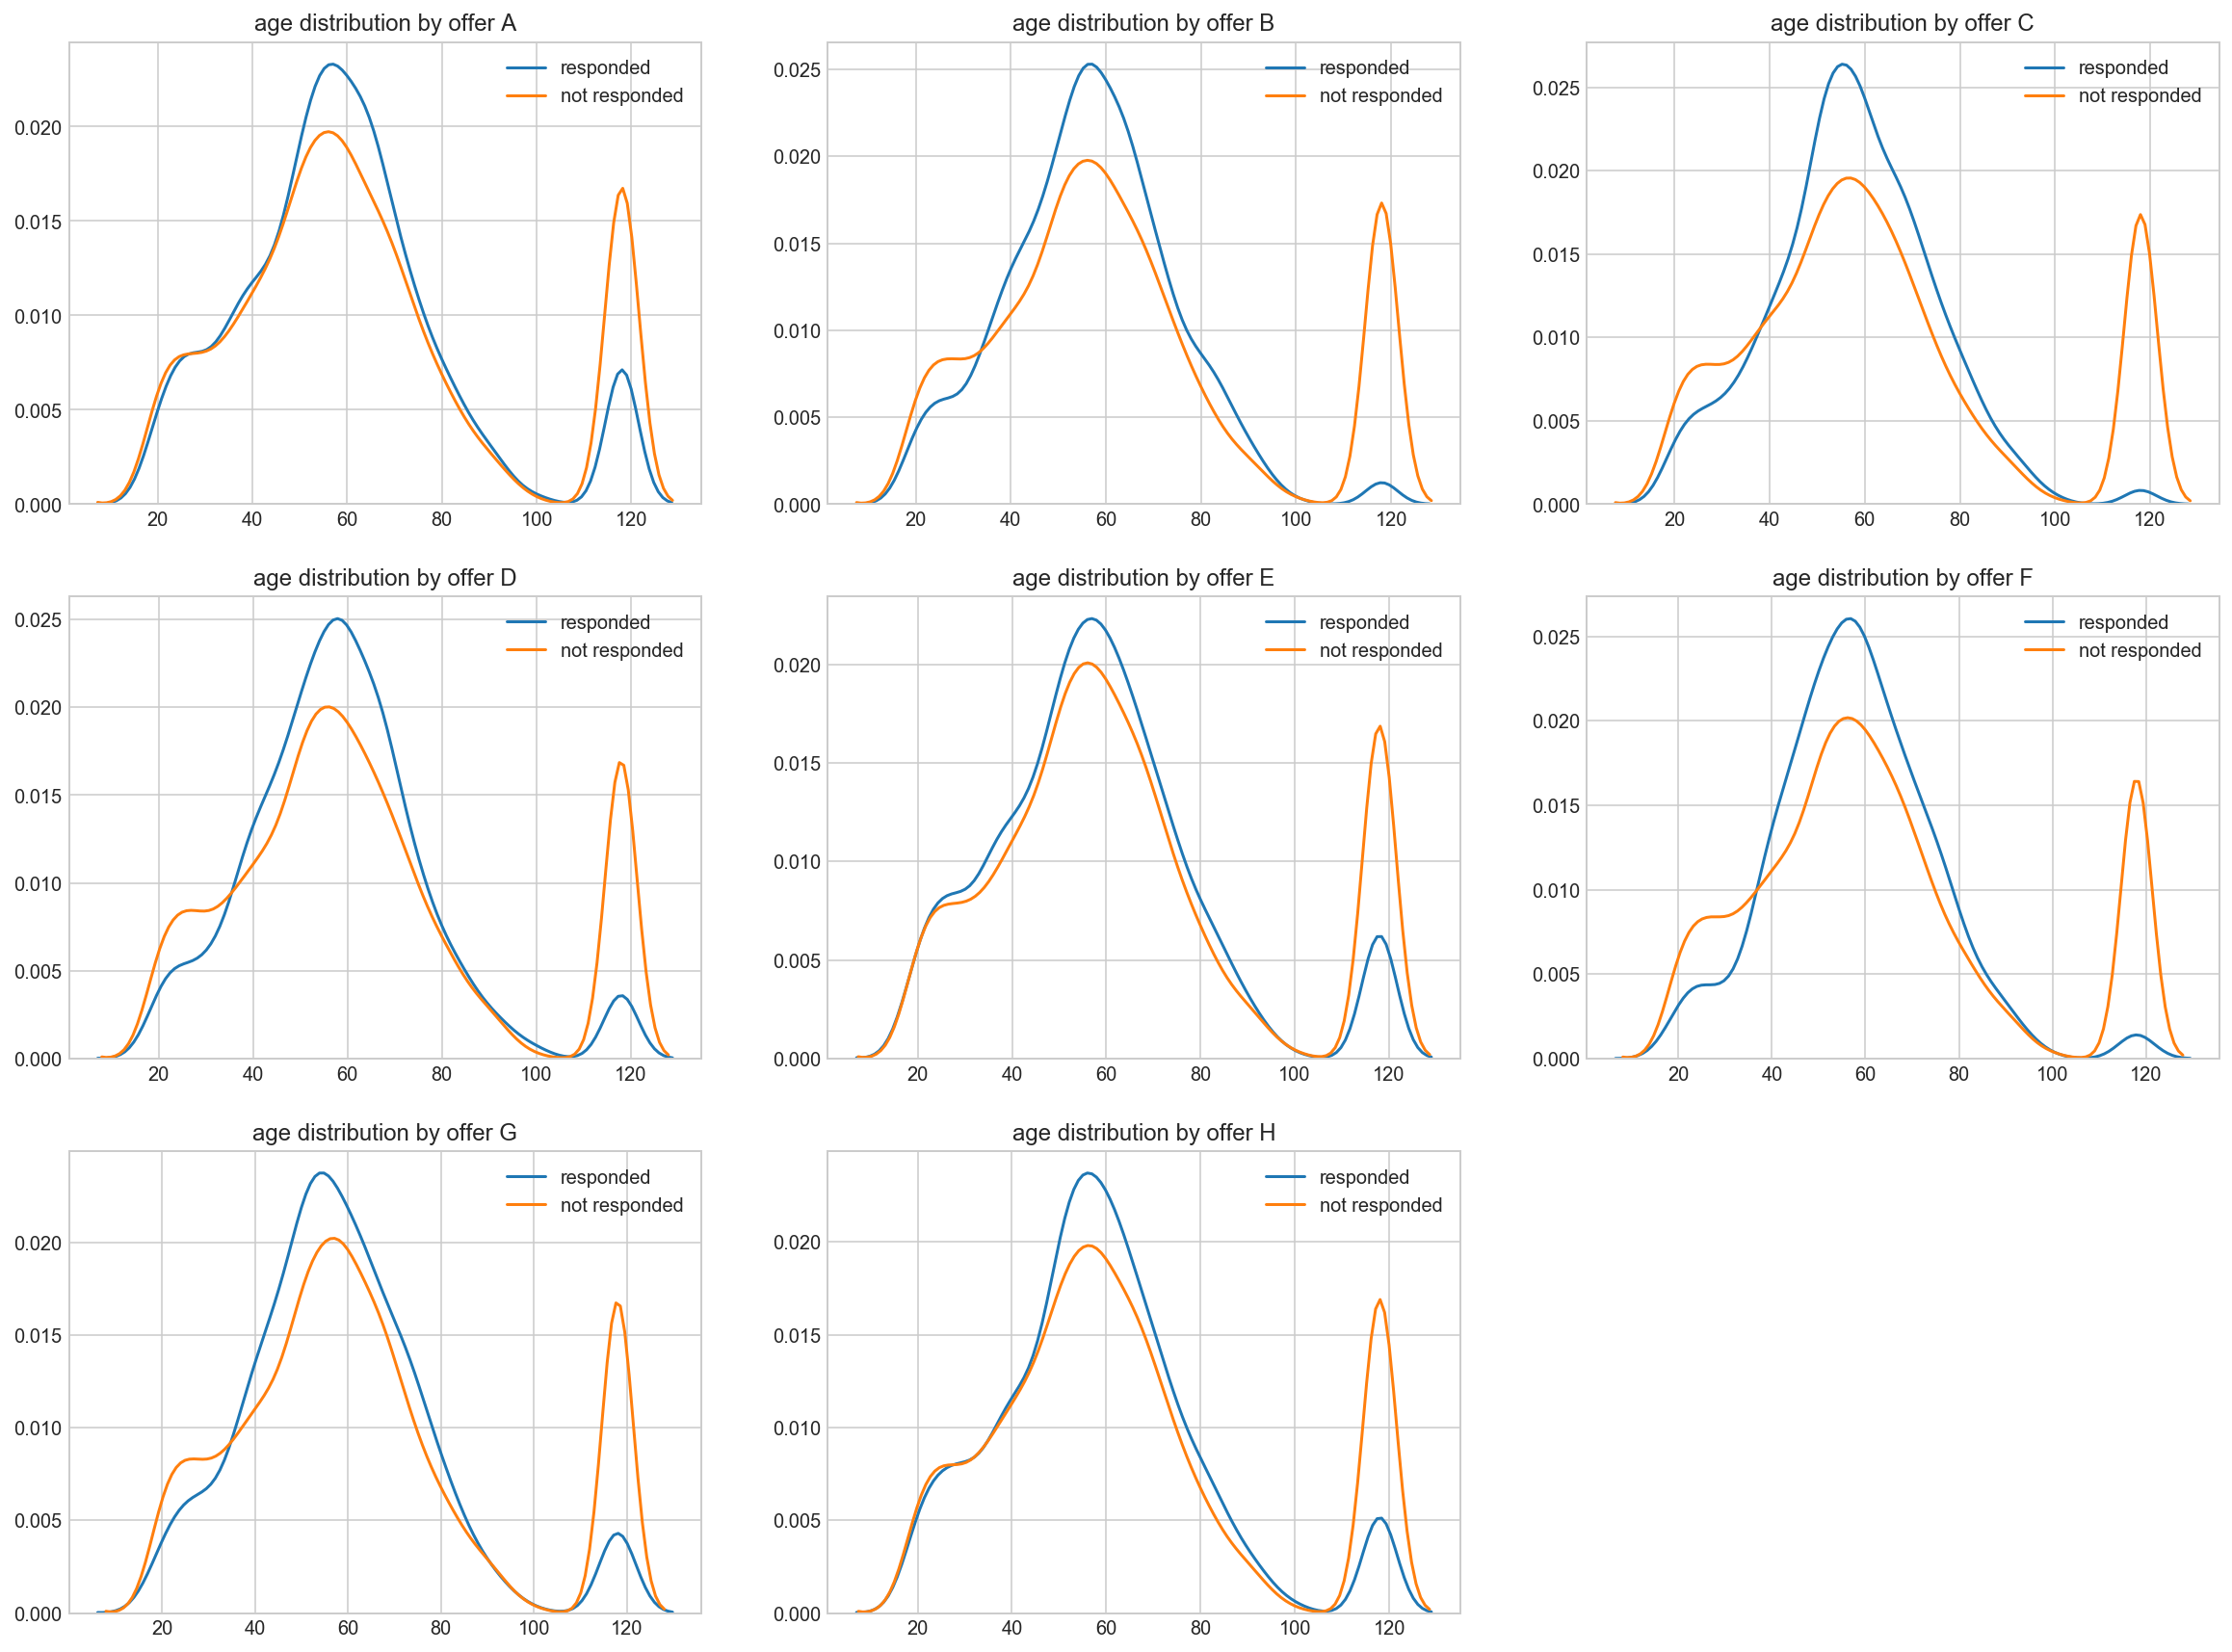

In [57]:
plot_distribution_by_offer_id('age')

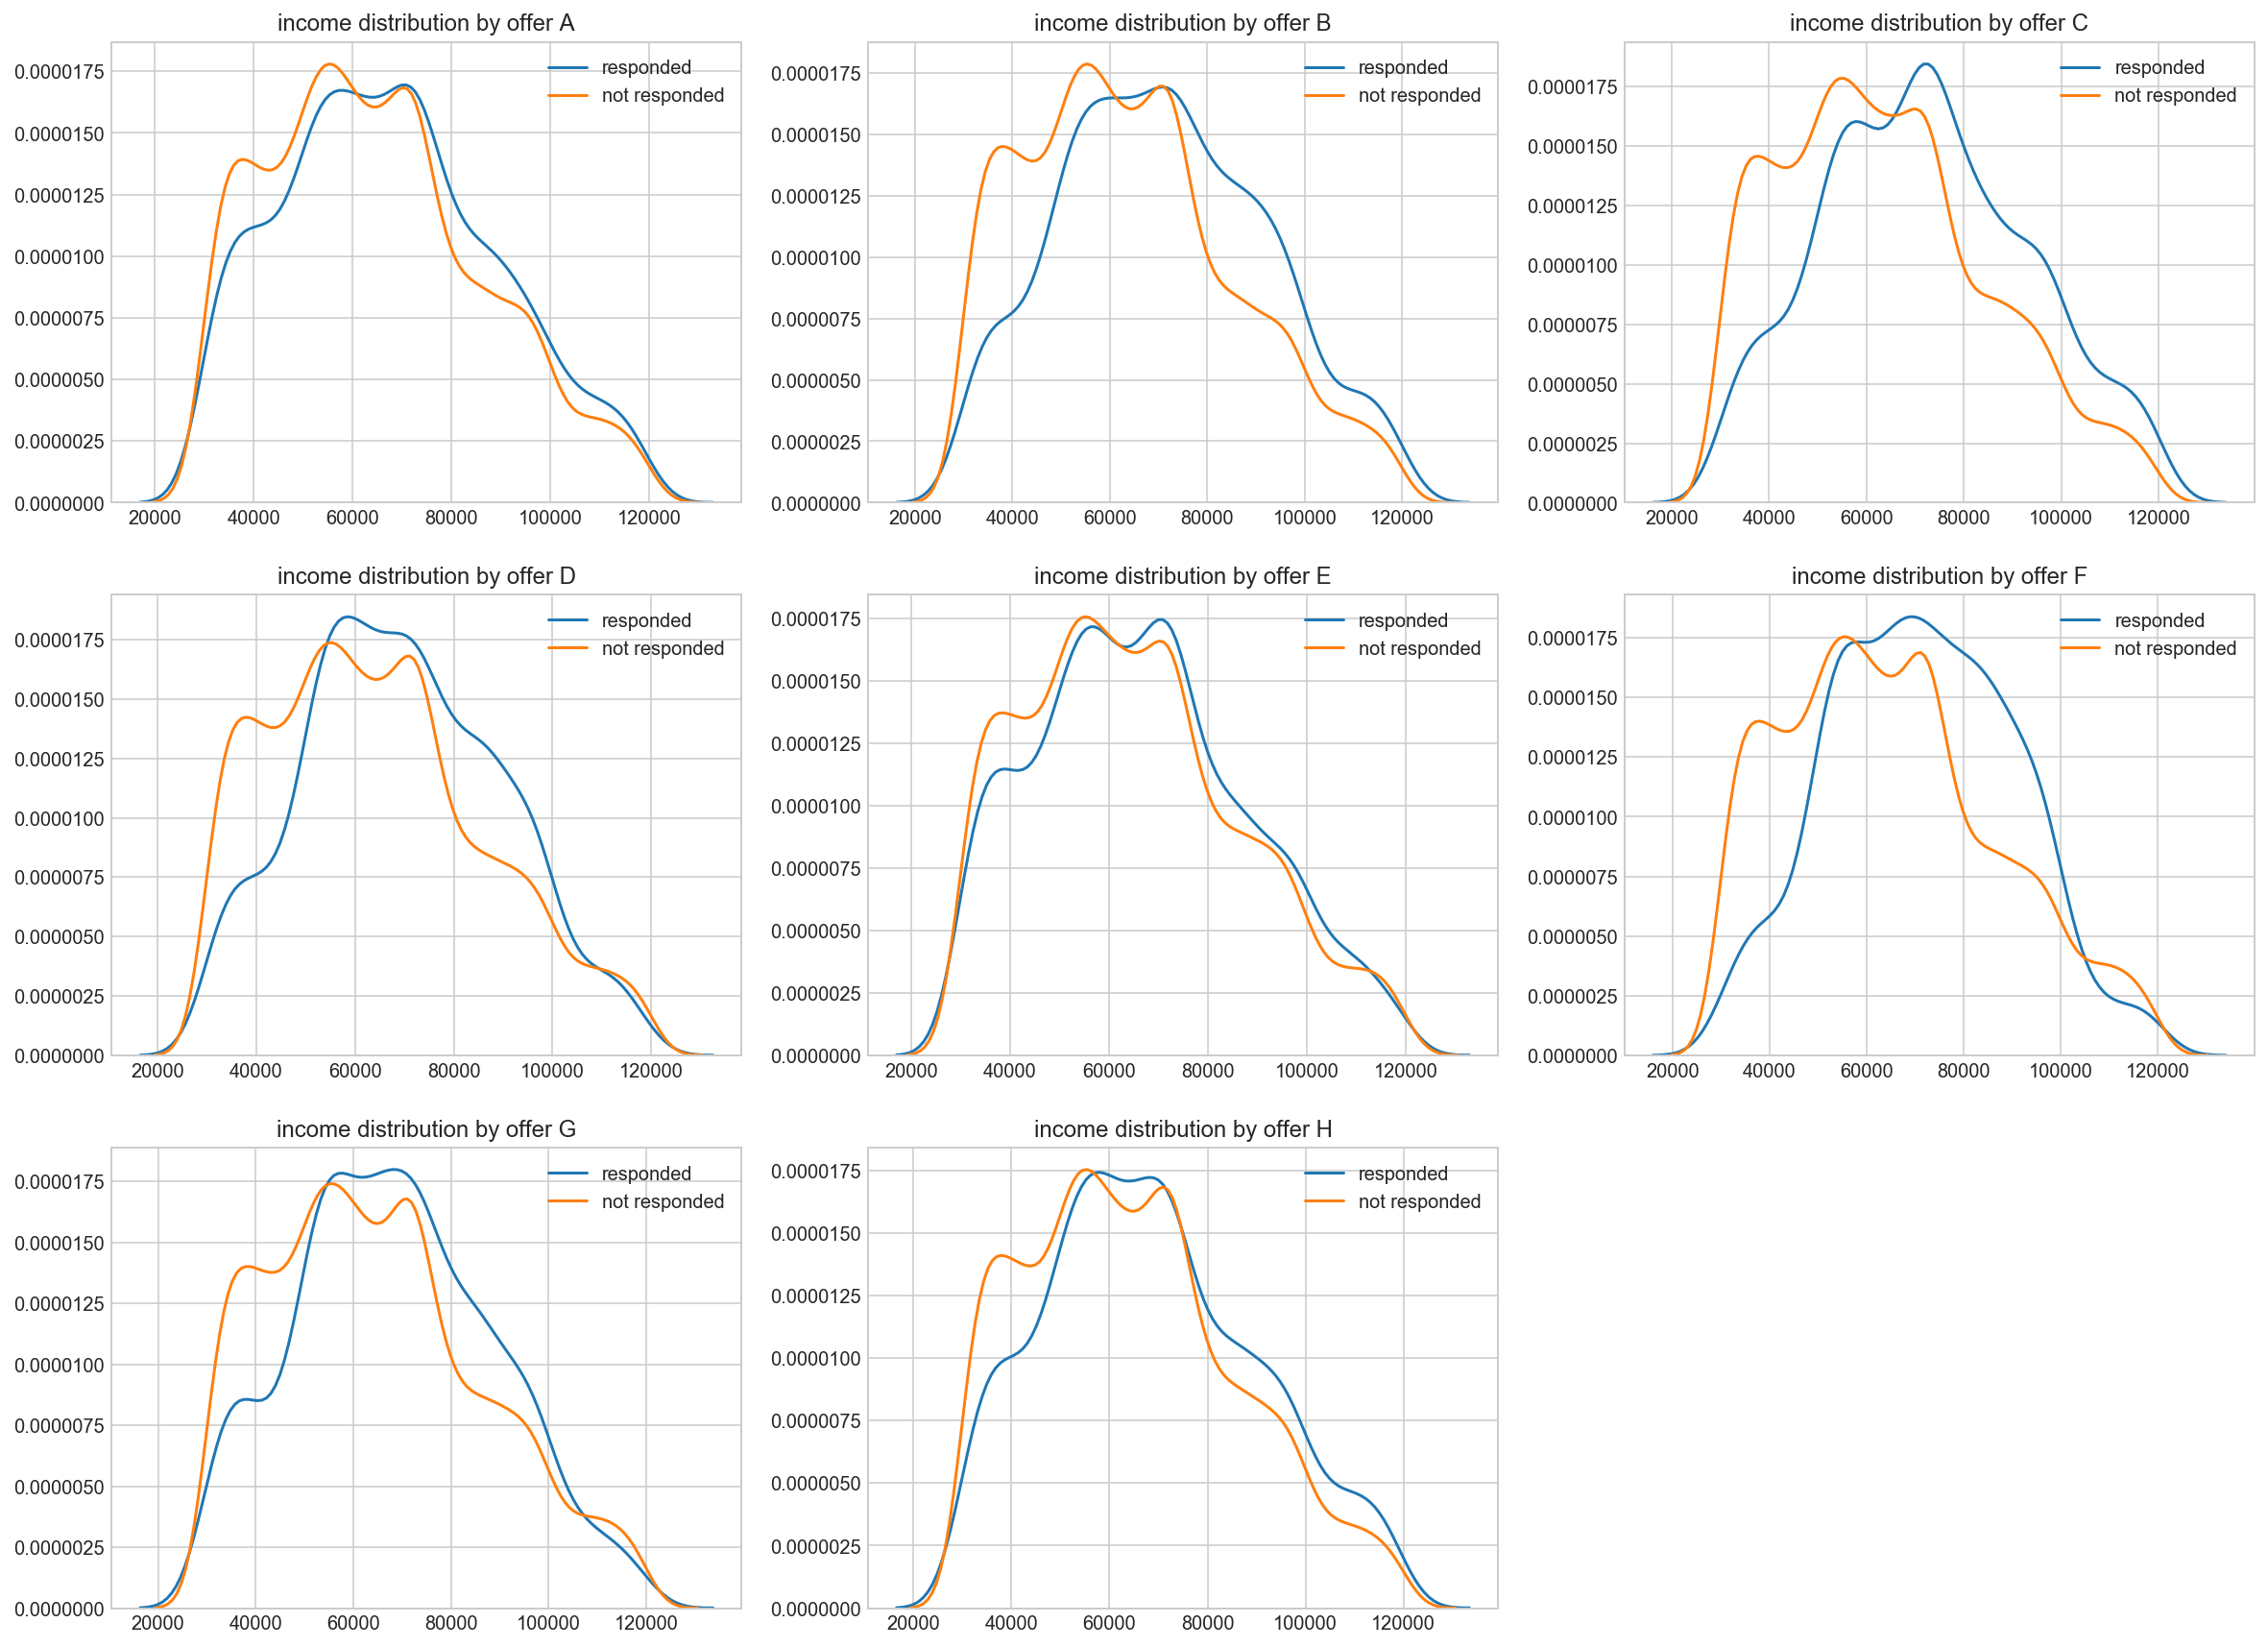

In [58]:
plot_distribution_by_offer_id('income')

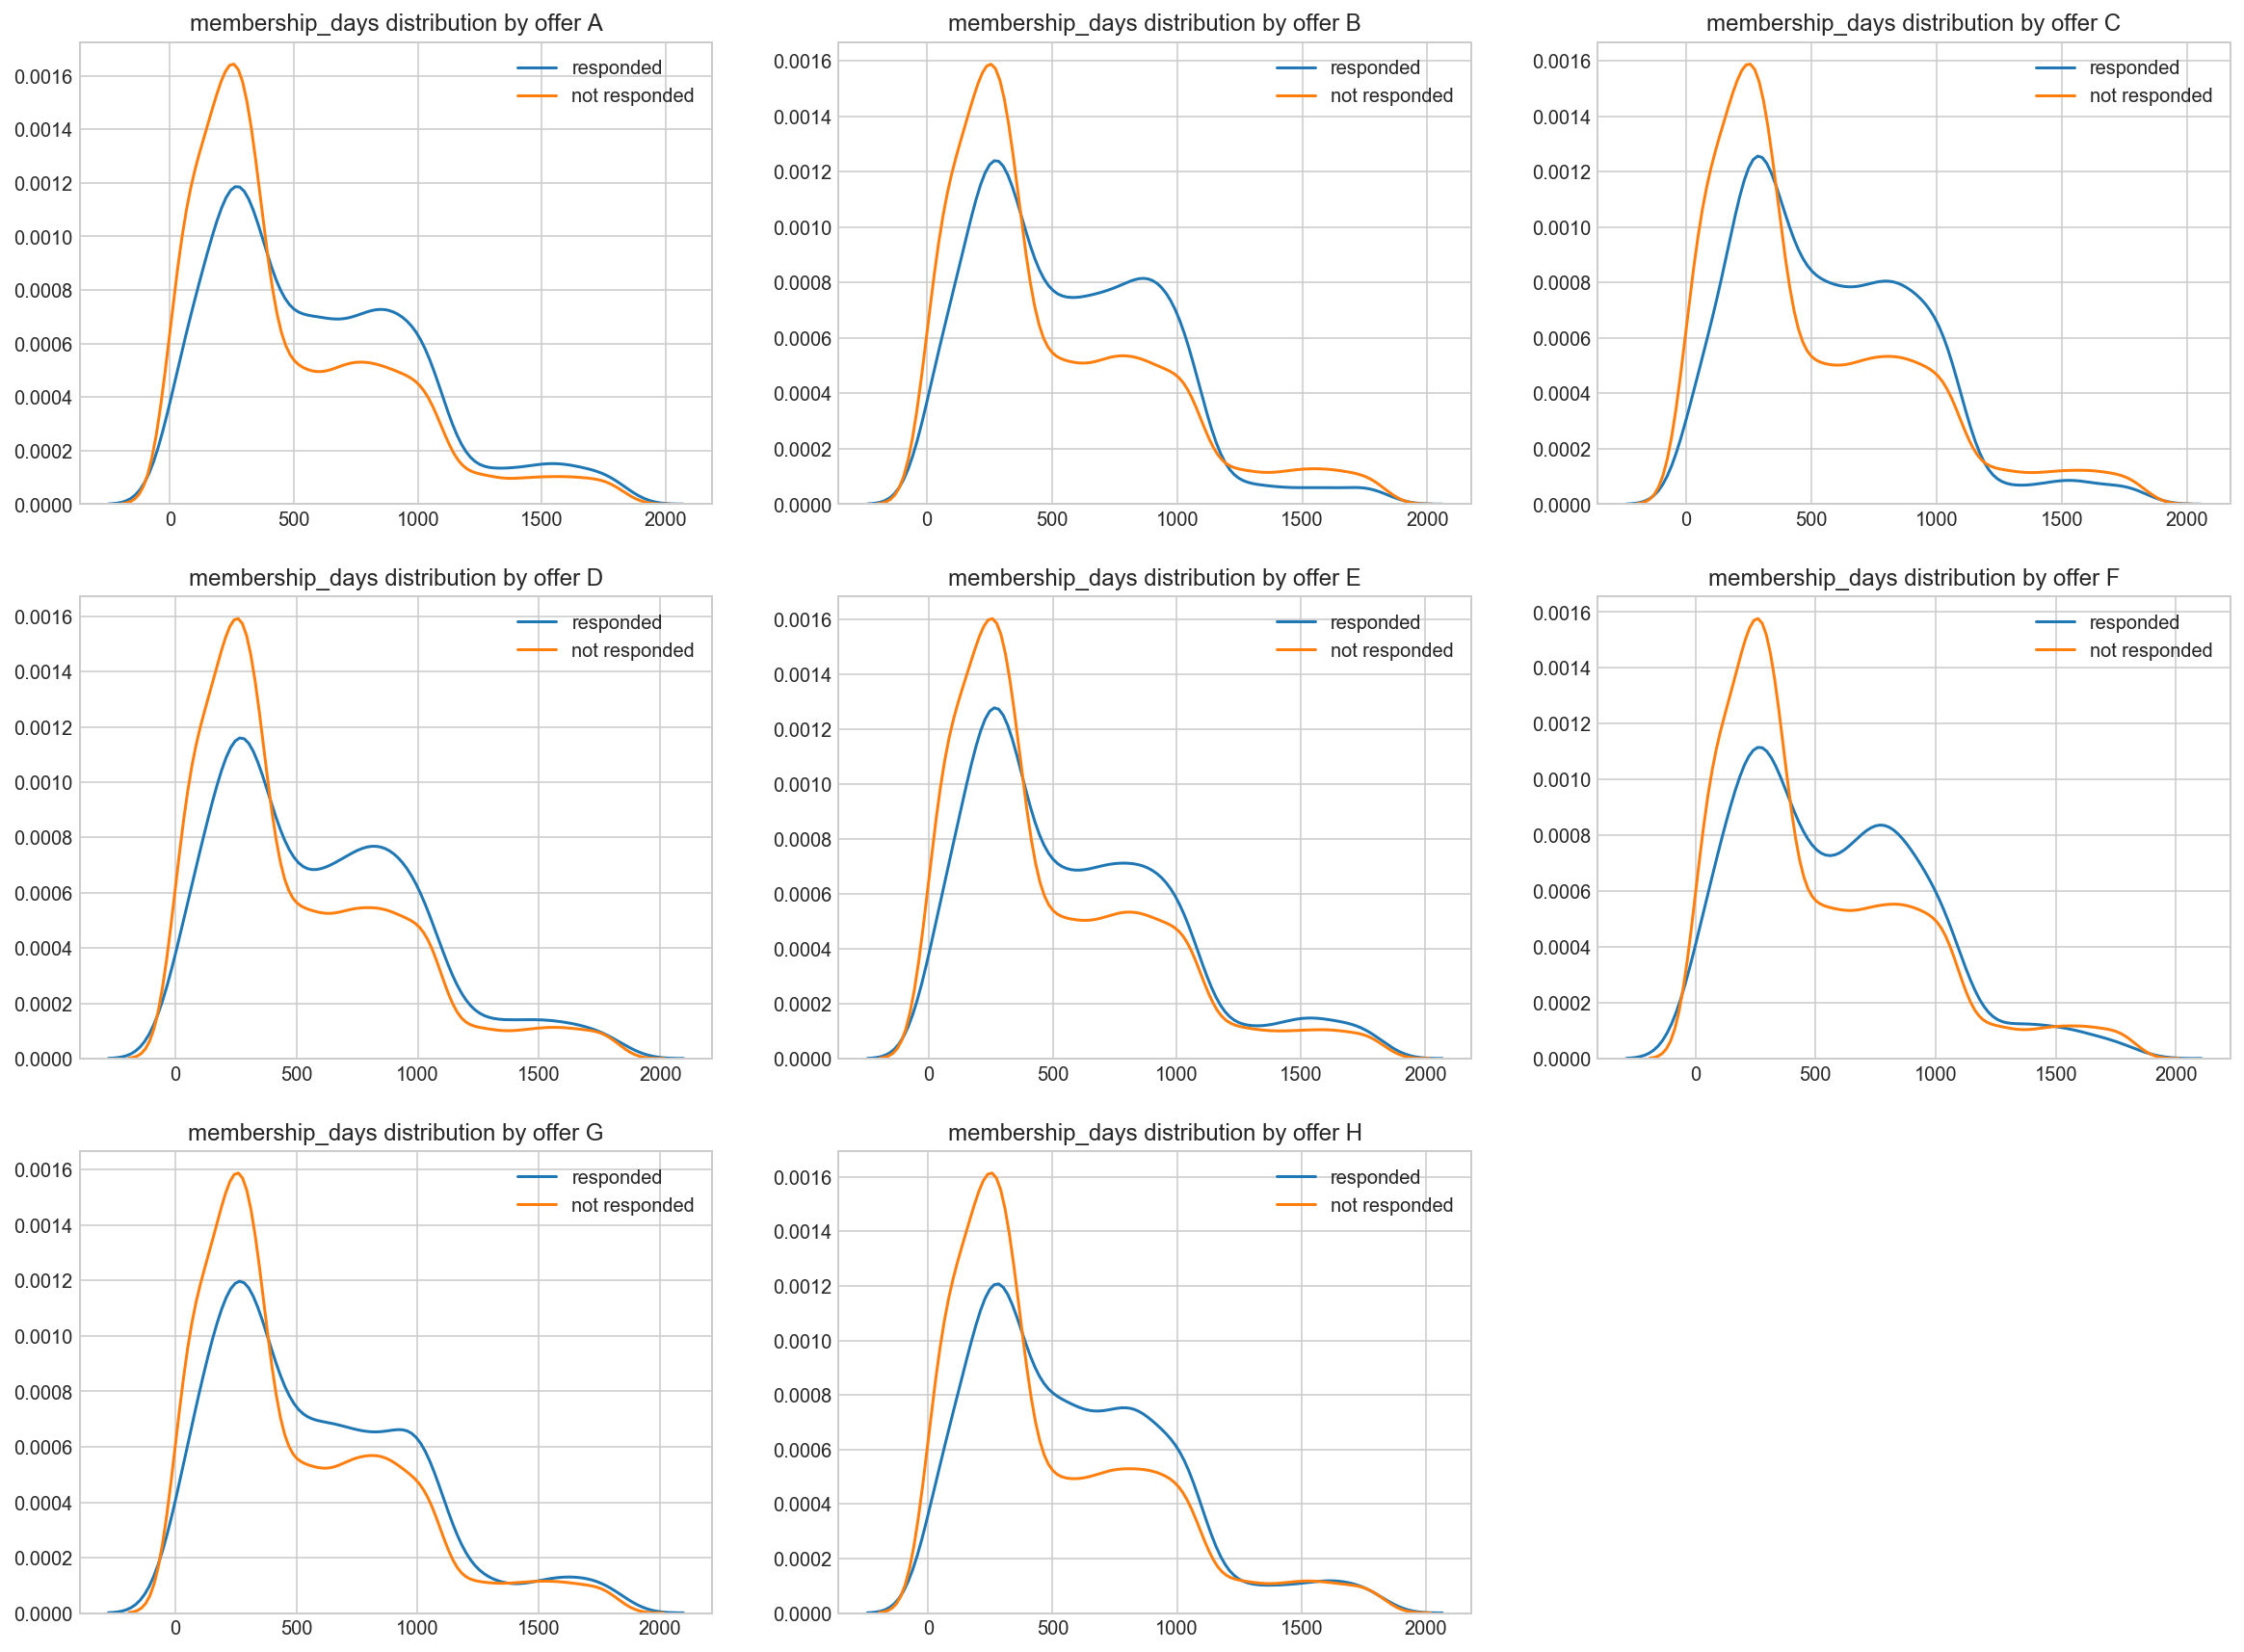

In [59]:
plot_distribution_by_offer_id('membership_days')

In [61]:
# # Plot barplot comparisons
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# sns.countplot(data=customers, x='gender', hue='discount_response');
# plt.title('Discount response')
# plt.legend(['not responded','responded'])

# plt.subplot(1,2,2)
# sns.countplot(data=customers, x='gender', hue='bogo_response');
# plt.title('BOGO response')
# plt.legend(['not responded','responded'])
# plt.tight_layout()

In [80]:
customers.head()

,gender,age,id,became_member_on,income,membership_days,G,F,D,A,C,H,E,B,bogo,discount
0,unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,529,0,0,0,1,0,0,1,0,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,0,0,0,0,0,0,0,0,0,0
2,unknown,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,14,0,0,0,0,0,0,0,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,1,0,0,0,0,1,0,1,1,0
4,unknown,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,356,0,0,0,0,0,0,0,0,0,0


In [85]:
pd.cut(customers.age, bins=5).value_counts()

(38.0, 58.0]     5673
(58.0, 78.0]     5015
(17.9, 38.0]     2918
(98.0, 118.0]    2197
(78.0, 98.0]     1197
Name: age, dtype: int64

In [87]:
pd.cut(customers.income, bins=5).value_counts()

(48000.0, 66000.0]      6655
(66000.0, 84000.0]      3706
(29910.0, 48000.0]      3624
(84000.0, 102000.0]     2105
(102000.0, 120000.0]     910
Name: income, dtype: int64

In [90]:
pd.cut(customers.membership_days, bins=5).value_counts()

(-1.823, 364.6]     8691
(364.6, 729.2]      3463
(729.2, 1093.8]     3453
(1458.4, 1823.0]     705
(1093.8, 1458.4]     688
Name: membership_days, dtype: int64

# Additional data cleaning before modeling

In [65]:
# Examine the ratios of target classes to decide on the classification metrics
# Accuracy seems like a good metric for balanced classes
print('discount response class ratios:')
print(customers.discount.value_counts() / len(customers))
print('\n')
print('bogo response class ratios')
print(customers.bogo.value_counts() / len(customers))

discount response class ratios:
1    0.553176
0    0.446824
Name: discount, dtype: float64


bogo response class ratios
1    0.517882
0    0.482118
Name: bogo, dtype: float64


In [66]:
# The ratio of responses in the null values in 'gender' is more imbalanced than not null
print('discount response class for null values in gender')
print(customers[customers.gender.isnull()].discount.value_counts())
print('\n')
print('discount response class for not-null values in gender')
print(customers[customers.gender.notnull()].discount.value_counts())

# As a result, convert the null values into another class/feature for modeling
customers.gender.fillna('unknown',inplace=True)

# Impute null values in income with median income
customers.income.fillna(np.median(customers.income.dropna()),inplace=True)

discount response class for null values in gender
0    1617
1     558
Name: discount, dtype: int64


discount response class for not-null values in gender
1    8846
0    5979
Name: discount, dtype: int64


 # Build Models to classify customer response to offers
- By predicting whether a customer will respond to a certain type of offer (discount / bogo), we can build focused marketing campaigns to maximize returns

## Notes:
- 55% of customers responded to discount offers while 45% didn't respond
- 51% of customers responded to bogo offers while 48 percent didn't respond
- Although classes are balanced, I would still choose F1 score as the metric
- Because I'd like to make sure all customers who will respond gets the offer, in the expense of those who won't respond getting the offer

In [68]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_days']]
# y = customers['discount']

# Convert categorical features into dummy variables
X = pd.get_dummies(X)

In [28]:
# print('cross validation scores for AdaBoost:', cross_val_score(AdaBoostClassifier(), X, y, scoring="f1", cv=5))
# print('cross validation scores for RandomForest:', cross_val_score(RandomForestClassifier(), X, y, scoring='f1', cv=5))
# print('cross validation scores for LogisticRegression:', cross_val_score(LogisticRegression(), X, y, scoring='f1', cv=5))

## Compare ROC AUC for both target variables (discount, bogo)

In [77]:
def compare_roc(target):

    # Set discount_response as the target variable
    y = customers[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title(f'{target} offer ROC')

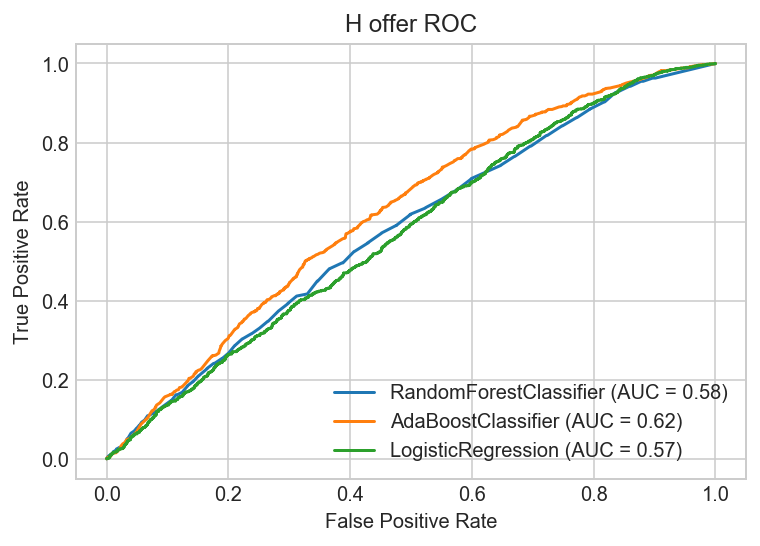

In [79]:
compare_roc('H')

# Use GridSearchCV to find the best parameters for AdaBoost

In [59]:
# Get available parameters
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [91]:
y = customers['bogo_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

bogo_cv = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1', return_train_score=True)
bogo_cv.fit(X_train, y_train)
print(f'best parameters: {bogo_cv.best_params_}')
# print(bogo_cv.cv_results_)
y_pred = bogo_cv.predict(X_test)
print(f'f1 score on the test data: {f1_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 30}
f1 score on the test data: 0.7269287365986966


In [92]:
y = customers['discount_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

discount_cv = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1', return_train_score=True)
discount_cv.fit(X_train, y_train)
print(f'best parameters: {discount_cv.best_params_}')
# print(discount_cv.cv_results_)
y_pred = discount_cv.predict(X_test)
print(f'f1 score on the test data: {f1_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 10}
f1 score on the test data: 0.7421795133919444


### Find the optimal probability threshold for the highest F1 scores
- In practice, we can lower the threshold because there is little harm to send offers to those who won't respond

In [93]:
def find_best_threshold(model, plot=False):

    # create a hash table of thresholds vs f1 scores
    res = dict()
    y_proba_pred = model.predict_proba(X_test)[:,1]

    for threshold in np.linspace(0,1):
        res[threshold] = f1_score(y_test, [1 if p > threshold else 0 for p in y_proba_pred])

    # Find the optimal probability thresholds for the max f1 score
    for key,value in res.items():
        if value == max(res.values()):
            print(key)

    if plot == True:
        # plot probability threshold VS F1 scores
        plt.plot(list(res.keys()), list(res.values()));
        plt.title('F1 scores by probability thresholds');

0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041


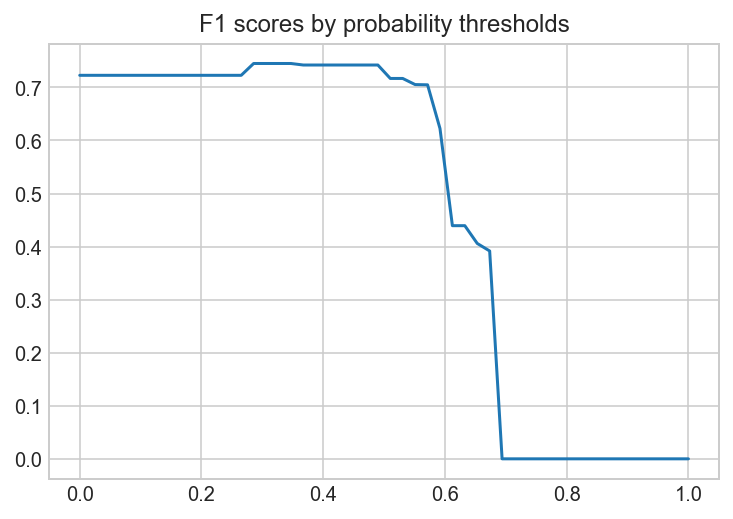

In [98]:
# The best threshold for predicting bogo response is between 0.28 and 0.34 for this test data
find_best_threshold(bogo_cv, plot=True)

0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464


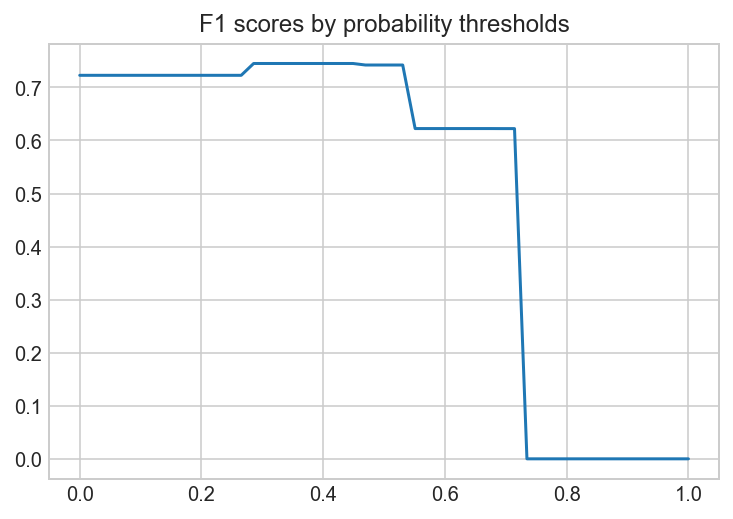

In [101]:
# The best threshold for predicting discount response is between 0.28 and 0.45 for this test data
find_best_threshold(discount_cv, plot=True)

In [102]:
# Save the two models for classifying discount and bogo responses
joblib.dump(discount_cv, 'discount_clf.pkl')
joblib.dump(bogo_cv, 'bogo_clf.pkl')

['bogo_clf.pkl']